# Modelbuilding Restwertermittlung

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, normaltest, anderson
from scipy import stats
from sklearn.preprocessing import QuantileTransformer

from sklearn import svm
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from IPython.display import Image

In [4]:
# loading dataframe
df = pd.read_csv("/Users/cenkyagkan/books/mynewbook/content/mobile_clean_data_without_outlier.csv")

# displaying dataframe
df.head()

,carname,price,milage,hubraum,fuel_type,transmission,num_seats,num_doors,emission_class,car_type,num_owners,Model,power_ps,age
0,Mercedes-Benz Sprinter II Kasten 214 CDI Klima...,16950.0,198245.0,2.143,Diesel,Schaltgetriebe,3,4/5,Euro6,van,1,Sprinter,143.0,4.246667
1,Mercedes-Benz GLB 220 d 4M Progressive AHK Dis...,60490.0,10529.0,1.950,Diesel,Automatik,5,4/5,Euro6d,suv,1,GLB,190.0,1.413333
2,Mercedes-Benz A 200 7G*1.HAND*LED*NAVI*LEDER*K...,24990.0,91205.0,1.332,Benzin,Automatik,5,4/5,Euro6d,limousine,1,A-Klasse,136.0,2.496667
3,Mercedes-Benz C 180 *CABRIO*AMG LINE*9G*2.HAND...,31990.0,84925.0,1.595,Benzin,Automatik,4,2/3,Euro6,cabrio,2,C-Klasse,156.0,4.746667
4,Mercedes-Benz A 180 7G*1.HAND*LED*NAVI*LEDER*K...,24990.0,91205.0,1.332,Benzin,Automatik,5,4/5,Euro6d,limousine,1,A-Klasse,136.0,2.496667


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carname         799 non-null    object 
 1   price           799 non-null    float64
 2   milage          799 non-null    float64
 3   hubraum         799 non-null    float64
 4   fuel_type       799 non-null    object 
 5   transmission    799 non-null    object 
 6   num_seats       799 non-null    int64  
 7   num_doors       799 non-null    object 
 8   emission_class  799 non-null    object 
 9   car_type        799 non-null    object 
 10  num_owners      799 non-null    int64  
 11  Model           799 non-null    object 
 12  power_ps        799 non-null    float64
 13  age             799 non-null    float64
dtypes: float64(5), int64(2), object(7)
memory usage: 87.5+ KB


## Minimal Preprocessing

In [8]:
df['carname'] = df['carname'].astype("category")
df['fuel_type'] = df['fuel_type'].astype("category")
df['transmission'] = df['transmission'].astype("category")
df['num_seats'] = df['num_seats'].astype("category")
df['num_doors'] = df['num_doors'].astype("category")
df['emission_class'] = df['emission_class'].astype("category")
df['car_type'] = df['car_type'].astype("category")
df['num_owners'] = df['num_owners'].astype("category")
df['Model'] = df['Model'].astype("category")

## Test- und Trainingsdaten

In [16]:
X = df.drop(['carname', 'price'],axis=1)
y = df['price']

# Erstellen der Test- und Trainingsdaten 
X_train,X_test,y_train,y_test=train_test_split(X,y)

# Erstellen der Test- und Trainingsdaten ohne cat-Features
X_ohne_cat = df.drop(['carname', 'price', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model'],axis=1)
X_traincat,X_testcat,y_traincat,y_testcat=train_test_split(X_ohne_cat,y)

## Baseline Modelle

In [100]:
# Wahl der Algorithmen
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
lr = LinearRegression()
knn = KNeighborsRegressor()

# Listen und Dictionary zum Abspeichern der einzelnen Ergebnisse der Modelle
base_results = {}
scores = []
best_params = []
models = []
feats= []
trans = []
pipes = []
maes = []
rmses = []


# Alle Modelle werden in einer Liste abgespeichert, so dass über diese iteriert werden kann
models = [lr,knn,rfr,gbr]

for model in models:
    params={
         'simpleimputer__strategy':['mean','median','most_frequent']
    }

    # small preprocessing pipeline
    pipe=make_pipeline(SimpleImputer(),model)
    gs=GridSearchCV(pipe,params,n_jobs=-1,cv=5)
    gs.fit(X_traincat, y_traincat)
    y_pred = gs.predict(X_testcat)
     
    mae = mean_absolute_error(y_testcat, y_pred)
    mse = mean_squared_error(y_testcat, y_pred)
    
    scores.append(gs.score(X_testcat, y_testcat))
    best_params.append(gs.best_params_)
    maes.append(mae)
    rmses.append(math.sqrt(mse))


base_results = {'Algorithm': models, 'Best Params': best_params, 'Score': scores, 'MAE':maes, 'RMSE': rmses}
base_results_df = pd.DataFrame(base_results)

base_results_df

,Algorithm,Best Params,Score,MAE,RMSE
0,LinearRegression(),{'simpleimputer__strategy': 'mean'},0.713760,6288.141881,8275.907858
1,KNeighborsRegressor(),{'simpleimputer__strategy': 'mean'},0.467497,8786.186000,11287.844114
2,RandomForestRegressor(),{'simpleimputer__strategy': 'median'},0.855685,4138.421714,5876.324757
3,GradientBoostingRegressor(),{'simpleimputer__strategy': 'mean'},0.850342,4739.047474,5984.127375


**Nicht distanzbasierte Modelle:**
* RandomForestRegressor(), GradientBoostingRegressor() erzielen jetzt schon sehr gute Ergebnisse, da sie keine Normalverteilung, keine Standardisierung und keine Skalierung benötigen

**Distanzbasierte Modelle:**
* KNeighborsRegressor(), LinearRegression() erzielen schon gute Werte, jedoch liegen die Daten hierfür noch nicht in der richitgen Form vor. So müssen die Daten noch angepasst werden. 

## Modelbuliding with pipelines

In [94]:
# Jede Pipeline wird in Form eines Dictionaries abgespeichert, über das später dann iteriert wird.
# Alle pipelines sind immer gleich aufgebaut: Model, params, features, transformer
# Bei den Features wird in numeric und categoric features unterschieden, da diese sich im Preprocessing bzw. bei der Transformation nochmals unterscheiden 


pipelines = {
    "pipeline1": {

        "model": LinearRegression(),

        "params": {
            'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent']
        },

        "features": {
            "features": ['milage', 'hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'hubraum', 'power_ps', 'age'],
           "categoric_features": ['fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']
        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()),('power_transformer', PowerTransformer(method="box-cox"))]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])


    },
    
    "pipeline2": {

        "model": LinearRegression(),

        "params": {
            'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent']
        },

        "features": {
            "features": ['milage', 'hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'hubraum', 'power_ps', 'age'],
           "categoric_features": ['fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']
        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()),('power_transformer', PowerTransformer(method="yeo-johnson"))]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])


    },
    
    "pipeline3": {

        "model": LinearRegression(),

        "params": {
            'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent']
        },

        "features": {
            "features": ['milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']
        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()),('power_transformer', PowerTransformer(method="yeo-johnson"))]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])


    },
    
    "pipeline4": {

        "model": LinearRegression(),

        "params": {
            
           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],
           'preprocessor__num__quantil_transformer__n_quantiles':[1,2,3,4,5,6,7,8,9,10,20,30,50,100,500,1000],
           'preprocessor__num__quantil_transformer__output_distribution':['normal']
        },

        "features": {
            "features": ['milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']

        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()),('quantil_transformer', QuantileTransformer())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline5": {

        "model": LinearRegression(),

        "params": {
            
           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],

        },

        "features": {
            "features": ['milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']

        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()),('power_transformer', PowerTransformer(method="box-cox")), ('robustscaler', RobustScaler())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline6": {

        "model": LinearRegression(),

        "params": {
            
           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],

        },

        "features": {
            "features": ['milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']

        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()),('robustscaler', RobustScaler()), ('power_transformer', PowerTransformer(method="yeo-johnson"))]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline7": {

        "model": LinearRegression(),

        "params": {
            
           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],
           'preprocessor__num__quantil_transformer__n_quantiles':[1,2,3,4,5,6,7,8,9,10,20,30,50,100,500,1000],
           'preprocessor__num__quantil_transformer__output_distribution':['normal']
        },

        "features": {
            "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']

        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()),('quantil_transformer', QuantileTransformer())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline8": {

        "model": LinearRegression(),

        "params": {

           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],
           'preprocessor__num__quantil_transformer__n_quantiles':[1,2,3,4,5,6,7,8,9,10,20,30,50,100,500,1000],
           'preprocessor__num__quantil_transformer__output_distribution':['normal']
        },

        "features": {
            "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']

        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standard_scaler', StandardScaler()), ('quantil_transformer', QuantileTransformer())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline9": {

        "model": LinearRegression(),

        "params": {

           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent']
        },

        "features": {
            "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']

        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standard_scaler', StandardScaler())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline10": {

        "model": LinearRegression(),

        "params": {

           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent']
        },

        "features": {
            "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']

        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()), ('minmaxscaler', MinMaxScaler())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline11": {

        "model": KNeighborsRegressor(),

        "params": {

           'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],
           'model__n_neighbors':[5,6,7,8,9,10]
        },

        "features": {
            "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']


        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standard_scaler', StandardScaler())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
    "pipeline12": {

        "model": RandomForestRegressor(),


        "params": {
            'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent']


        },

        "features": {
            "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']


        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))]),

    },
    
    "pipeline13": {

        "model": RandomForestRegressor(),


        "params": {
            'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],
            'model__max_features': ['auto', 'sqrt'],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__bootstrap': [True, False]


        },

        "features": {
            "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']


        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))]),

    },
    
     "pipeline14": {

        "model": RandomForestRegressor(),

        "params": {
            'preprocessor__num__simpleimputer__strategy':['mean','median','most_frequent'],
            'model__max_features': ['auto', 'sqrt', 'log2'],
            'model__criterion': ['mse', 'mae'],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__bootstrap': [True, False]

        },

        "features": {
           "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']


        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer())]),
        "categoric_transformer": Pipeline(steps=[('onehotencoder',OneHotEncoder(handle_unknown='ignore'))])

    },
    
      "pipeline15": {
        "model": GradientBoostingRegressor(),
        "params": {
            "model__learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4],
            "model__min_samples_split": np.linspace(0.05, 0.9, 12),
            "model__min_samples_leaf": np.linspace(0.05, 0.9, 12),
            "model__max_depth":[3,5,8,10],
            "model__max_features":["log2","sqrt"],
            "model__criterion": ["friedman_mse",  "mae"],
            "model__subsample":[0.5, 0.85, 0.9, 0.95, 1.0, 1.5, 2.0],
            "model__n_estimators":[10]
        },

        "features": {
           "features": ['hubraum', 'milage', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model', 'power_ps', 'age'],
           "numeric_features": ['milage', 'power_ps', 'age'],
           "categoric_features": ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']


        },

        "numeric_transformer" : Pipeline(steps=[('simpleimputer', SimpleImputer())]),
        "categoric_transformer": Pipeline(steps=[('one_hot_encoder',OneHotEncoder(handle_unknown='ignore'))]),


    }
}

In [95]:

# now, create a list with the objects 
results = {}
scores = []
best_params = []
models = []
feats= []
trans = []
pipes = []
maes = []
rmses = []

# iterating all pipeline configurations
for pipeline in pipelines:

    params = pipelines[pipeline]["params"]

    features = pipelines[pipeline]["features"]["features"]

    X_train_2 = X_train.loc[:,features]
    X_test_2 = X_test.loc[:,features]

    numeric_features = pipelines[pipeline]["features"]['numeric_features']
    categoric_features = pipelines[pipeline]["features"]['categoric_features']

    numeric_transformer = pipelines[pipeline]["numeric_transformer"]
    categoric_transformer = pipelines[pipeline]["categoric_transformer"]

    model = pipelines[pipeline]["model"]


    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)])

    pre_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])


    # GridSearch
    gs=GridSearchCV(pre_pipe,params,n_jobs=-1,cv=5)
    gs.fit(X_train_2, y_train)
    
    y_pred = gs.predict(X_test_2)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    models.append(model)
    scores.append(gs.score(X_test_2, y_test))
    best_params.append(gs.best_params_)
    feats.append(features)
    trans.append(preprocessor)
    pipes.append(pipeline)
    maes.append(mae)
    rmses.append(math.sqrt(mse))

    print(pipeline,'done')
    

results = {'Pipe':pipes,'Algorithm': models, 'Features': feats,'Best Params': best_params, 'Preprocessor': trans, 'Score': scores, 'MAE':maes, 'RMSE': rmses}
results_df = pd.DataFrame(results)

pipeline1 done
pipeline2 done
pipeline3 done
pipeline4 done
pipeline5 done
pipeline6 done
pipeline7 done
pipeline8 done
pipeline9 done
pipeline10 done
pipeline11 done
pipeline12 done
pipeline13 done
pipeline14 done
pipeline15 done


In [96]:
results_df

,Pipe,Algorithm,Features,Best Params,Preprocessor,Score,MAE,RMSE
0,pipeline1,LinearRegression(),"[milage, hubraum, fuel_type, transmission, num...",{'preprocessor__num__simpleimputer__strategy':...,"ColumnTransformer(transformers=[('num',\n ...",0.765051,5348.887674,7231.330712
1,pipeline2,LinearRegression(),"[milage, hubraum, fuel_type, transmission, num...",{'preprocessor__num__simpleimputer__strategy':...,"ColumnTransformer(transformers=[('num',\n ...",0.760665,5383.203374,7298.501254
2,pipeline3,LinearRegression(),"[milage, fuel_type, transmission, num_seats, n...",{'preprocessor__num__simpleimputer__strategy':...,"ColumnTransformer(transformers=[('num',\n ...",0.761132,5446.242055,7291.381957
3,pipeline4,LinearRegression(),"[milage, fuel_type, transmission, num_seats, n...",{'preprocessor__num__quantil_transformer__n_qu...,"ColumnTransformer(transformers=[('num',\n ...",0.776982,5575.336601,7045.321459
4,pipeline5,LinearRegression(),"[milage, fuel_type, transmission, num_seats, n...",{'preprocessor__num__simpleimputer__strategy':...,"ColumnTransformer(transformers=[('num',\n ...",0.764354,5430.125020,7242.047461
5,pipeline6,LinearRegression(),"[milage, fuel_type, transmission, num_seats, n...",{'preprocessor__num__simpleimputer__strategy':...,"ColumnTransformer(transformers=[('num',\n ...",0.764147,5373.584558,7245.228900
6,pipeline7,LinearRegression(),"[hubraum, milage, fuel_type, transmission, num...",{'preprocessor__num__quantil_transformer__n_qu...,"ColumnTransformer(transformers=[('num',\n ...",0.812459,4805.231208,6460.701295
7,pipeline8,LinearRegression(),"[hubraum, milage, fuel_type, transmission, num...",{'preprocessor__num__quantil_transformer__n_qu...,"ColumnTransformer(transformers=[('num',\n ...",0.812459,4805.231118,6460.701191
8,pipeline9,LinearRegression(),"[hubraum, milage, fuel_type, transmission, num...",{'preprocessor__num__simpleimputer__strategy':...,"ColumnTransformer(transformers=[('num',\n ...",0.848577,4191.971581,5805.332513
9,pipeline10,LinearRegression(),"[hubraum, milage, fuel_type, transmission, num...",{'preprocessor__num__simpleimputer__strategy':...,"ColumnTransformer(transformers=[('num',\n ...",0.848577,4191.971689,5805.332250


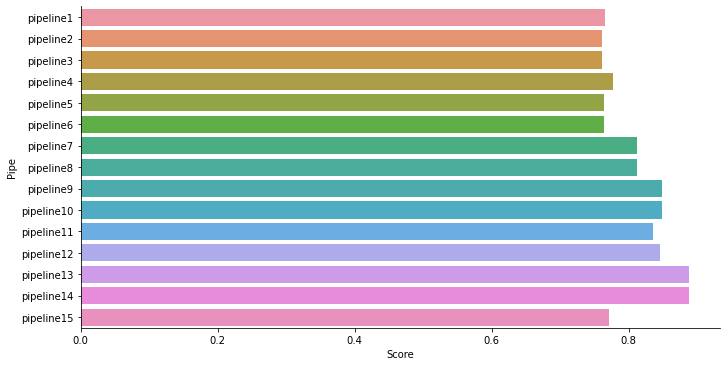

In [97]:
sns.factorplot(y='Pipe',x='Score',data = results_df,kind='bar',size=5,aspect=2);

## Erkenntnisse über die Modelle

### Lineare Regression
- Bei der linearen Regression, hat sich heruasgestellt, dass man mit dem MinMax Scaler und dem OnehotEncoder den besten Wert erzielt.
- In der Regressions Diagnostic wurde eigentlich erkannt, dass das Feature "hubraum" für eine Multikollinearität verantwortlich ist. Beim Testen hat sich jedoch gezeigt, dass das Modell mit dem Feature "hubraum" eine bessere Performance liefert.
- Vergleicht man das Baselinemodell mit dem Modell aus der Pipeline 10, kann man erkennen, dass man durch weitere Preprocessing-Schritte das Modell um 13,48% verbessert werden konnte.
- R2 = 0,848 -> Das Regressionsmodell erklärt 84,8% der Streuung.
- RMSE = 5805,33 -> Die vorhergesagten Werte liegen im Durchschnitt mit einem Abstand von 5805,33€ von den beobachteten Werten entfernt.
- MAE = 4191,97 -> Der durschnittliche Vertikale Abstand zu den beobachteten Werten liegt bei 4191,97.

### KNN Regression
- Die KNN Regression hat im Vergleich mit der linearen Regresion änhlich gut abgeschnitten.
- Auch hier hat sich gezeigt, dass weitere Preprocessing-Schritte einen positiven Eininfluss auf das Modell haben.
- Da die KNN Regression auf Distanzen basiert, war ein Scaling notwendig. Im Test hat sich gezeigt, dass man mit dem StandardScaler bessere Ergebnisse erzielt.
- Durch die GridSearch hat sich gezeigt, dass K = 5 der beste Wert ist, um ein besseres Ergebnis erzielen zu können.
- R2 = 0,835 -> Das Regressionsmodell erklärt 83,5% der Streuung.
- Und hat einen RMSE von 6046,44 und einen MAE von 4408,79.

### RandomForrest Regressor
- Mit dem RandomForrest Regressor konnte das beste Ergebniss erzielt werden.
- Im Vergleich zum Baselinemodell, konnte das Modell mit der Preprocessing-Pipeline das Ergebniss um 3,3% verbessern.
- Standardmäßig wurde immer der OneHotEncoder verwendet, um die kategorischen Variablen in der Regression zu nutzen.
- R2 = 0,888 -> Das Regressionsmodell erklärt 88,8% der Streuung.
- RMSE = 4986 -> Die vorhergesagten Werte liegen im Durchschnitt mit einem Abstand von 4986€ von den beobachteten Werten entfernt.
- MAE = 3279 -> Der durschnittliche Vertikale Abstand zu den beobachteten Werten liegt bei 3279.

### GradientBoosting Regressor
- Der GradientBoosting Regressor hat trotz einer unfangreichen Gridsearch einer der schlechteren Ergebnisse erzielt.
- Mit weiteren Hyperparamter-Tunng wäre sicherlich noch ein besseres Ergebniss möglich.

## Bestes Modell

In [129]:
best_pipeline = results_df[results_df.Pipe == "pipeline14"]
list(best_pipeline['Best Params'])

[{'model__bootstrap': False,
  'model__criterion': 'mse',
  'model__max_features': 'sqrt',
  'model__min_samples_leaf': 1,
  'model__min_samples_split': 2,
  'preprocessor__num__simpleimputer__strategy': 'mean'}]

In [137]:
model = RandomForestRegressor()

params = {'preprocessor__num__simpleimputer__strategy':['mean'],
          'model__bootstrap': [False],
          'model__criterion': ['mse'],
          'model__max_features': ['sqrt'],
          'model__min_samples_leaf': [1],
          'model__min_samples_split': [2],
         }

numeric_features = ['milage', 'power_ps', 'age']
categoric_features = ['hubraum', 'fuel_type', 'transmission', 'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners', 'Model']



numeric_transformer = Pipeline(steps=[('simpleimputer', SimpleImputer())])
categoric_transformer = Pipeline(steps=[('onehotencoder',OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)])

pre_pipe = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])

    # GridSearch
gs=GridSearchCV(pre_pipe,params,n_jobs=-1,cv=5)
gs.fit(X_train, y_train)
    
y_pred = gs.predict(X_test)

## Actual vs Predicted

In [141]:
d = {'y_test': y_test, 'y_pred': y_pred}
df_result = pd.DataFrame(data=d)

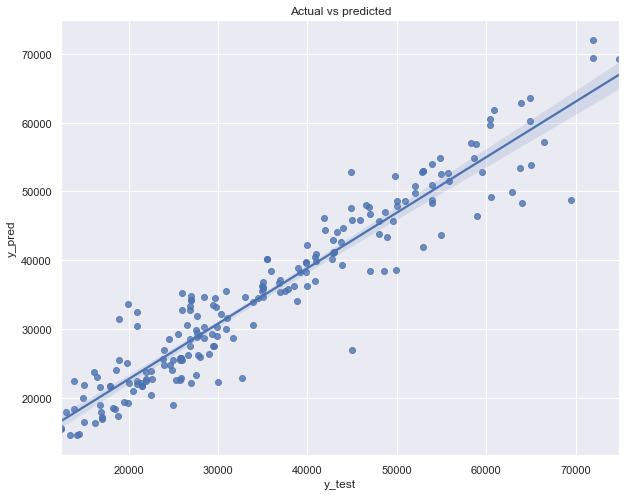

In [187]:
sns.set(rc={'figure.figsize':(10,8)})
fig = sns.regplot(data = df_result, x=y_test, y=y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Actual vs predicted")
plt.show(fig)

- R2 = 0,88
- RMSE = 4986

In [194]:
df_res['y_pred'] = y_pred
df_res['price'] = y_test

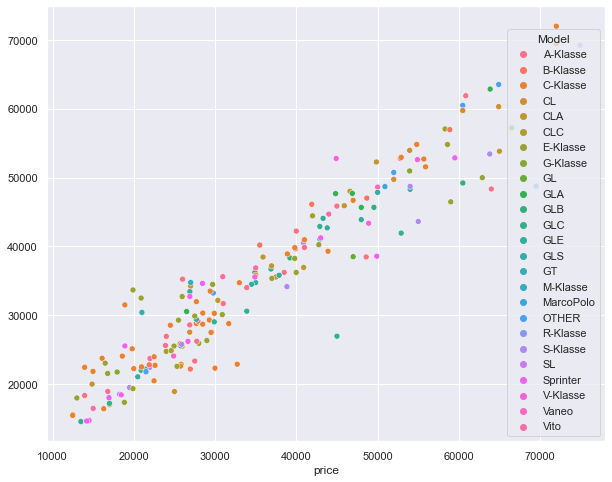

In [206]:
sns.scatterplot(data = df_res, x=y_test, y=y_pred, hue='Model' );